In [19]:
import pandas
import numpy
import datetime
import sklearn
import matplotlib.pyplot as pyplot
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

from bokeh.io import curdoc, push_notebook
from bokeh.layouts import layout, widgetbox
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Magma256 as palette
from bokeh.models.widgets import Slider, Select
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar



In [2]:
def BokehMap(dict_data,d_min, d_max,title_str,cb_str):
    us_states = numpy.load('us_states.npy').item()
    
#    us_counties = us_counties.data.copy()
#    unemployment = unemployment.data
    
    del us_states["HI"]
    del us_states["AK"]
    #del dict_data["HI"]
    #del dict_data["AK"]
    
    state_xs = [us_states[code]["lons"] for code in us_states]
    state_ys = [us_states[code]["lats"] for code in us_states]
    
    #county_xs=[us_counties[code]["lons"] for code in us_counties if us_counties[code]["state"] not in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]]
    #county_ys=[us_counties[code]["lats"] for code in us_counties if us_counties[code]["state"] not in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]]
    
    #colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
    
    #county_colors = []
    state_colors = []
    state_data = []
    for state_id in us_states.keys():
    #    state_id = state_id.lower()
    #    if us_counties[county_id]["state"] in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]:
    #        continue
        try:
    #        rate = numpy.nanmean([unemployment[code] for code in us_counties
    #                             if us_counties[code]['state']==state_id])
            data = dict_data[state_id]
    #        print state_id, data
            state_data.append(data)
    #        state_colors.append(colors[idx])
        except KeyError:
    #        state_colors.append("black")
            state_data.append(0.0)
    
#    output_file("choropleth.html", title="choropleth.py example")
#    output_notebook()
    #palette.reverse()
    color_mapper = LogColorMapper(palette=palette, low = d_min, high = d_max)
    
    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=us_states.keys(),
        data=state_data,
    ))
    #p = figure(title="US Unemployment 2009", toolbar_location="left",
    #    plot_width=1100, plot_height=700)
    TOOLS = "pan,wheel_zoom,reset,hover,save"


    p = figure(title=title_str, tools=TOOLS,plot_width=990, plot_height=630)
#   plot_width=1100, plot_height=700
#        )
    #p.patches(county_xs, county_ys, fill_color=county_colors, fill_alpha=0.7,
    #    line_color="white", line_width=0.5)
    #p.patches(state_xs, state_ys,source=source, fill_color=state_colors,fill_alpha=0.7,
    #    line_color="#884444", line_width=2)
    p.patches('x', 'y', source=source,
              fill_color={'field': 'data', 'transform': color_mapper},
              fill_alpha=1.0, line_color="#884444", line_width=1.0)

    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(), label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        (title_str+' ('+cb_str+')', "@data"),
        ("(Long, Lat)", "($x, $y)"),
        ]
    show(p) 

In [3]:
df = pandas.read_csv('openpv_all.csv',engine='python')
df['date'] = pandas.to_datetime(df['date_installed']).apply(lambda dt: dt.replace(day=15))
df['year'] = df['date_installed'].str.slice(-4).astype(float)
df['count'] = 1.
df['rebates']=df['rebate'].str.strip('$-').str.replace(',','').astype(float)
df['pct_reported_prod'] = 100*df.reported_annual_energy_prod/df.annual_PV_prod
df['install_type'] = df['install_type'].str.lower().str.split().str[0]
df['state'] = df['state'].str.strip()

stateinsol = pandas.read_csv('stateinsolations.csv')
stateinsol.head()

def NewInsol(x):
    if numpy.isnan(x['annual_insolation']):
        temp_ = stateinsol[(stateinsol['StateID'] == x['state'])]['Insolation']
        return temp_.item()
         
    else:
        return x['annual_insolation']
df['new_insolation'] = df[['annual_insolation','state']].apply(NewInsol,axis=1)

In [31]:
def NewInsol(x):
    if numpy.isnan(x['annual_insolation']):
        temp_ = stateinsol[(stateinsol['StateID'] == x['state'])]['Insolation']
        return temp_.item()
         
    else:
        return x['annual_insolation']
df['new_insolation'] = df[['annual_insolation','state']].apply(NewInsol,axis=1)

In [6]:
insol = df.groupby(['state'])['new_insolation'].mean()
insoldat = insol.to_dict()
#print insol
#print insoldat
output_notebook()
BokehMap(insoldat,3,7,'Incident Solar Radiation','')

Loading BokehJS ...

In [8]:
pvnum = df.groupby('state')['count'].sum().replace(numpy.nan,0.)
pvnumdat = pvnum.to_dict()
BokehMap(pvnumdat,1,1000000,'Number of Solar Installation','')

In [15]:
cost = df.groupby('state')['cost'].sum().replace(numpy.nan,0.)/1000000.
costdat = cost.to_dict()
BokehMap(costdat,1,10000,'Solar Investment ($M)','')

In [17]:
rebate = df.groupby('state')['rebates'].sum().replace(numpy.nan,0.)
rebatedat = rebate.to_dict()
BokehMap(rebatedat,1000,1e9,'Rebates ($)','')

In [22]:
from sklearn.linear_model import LinearRegression,Ridge

slopes = {}
for state in df['state'].value_counts().index:
    if state == 'DC' or state == 'PR':
        continue
    rdf = df[(df['install_type']=='residential')&(df['size_kw'] >= 0)&(df['state']==state)]

    data = rdf.loc[:,['rebates','cost','size_kw']].dropna()
    if data.shape[0] == 0:
        continue
    
    y = numpy.array(data['rebates']).reshape(-1,1)
    x = numpy.array(data['size_kw']).reshape(-1,1)

    linreg = Ridge(fit_intercept=False)
    line = linreg.fit(x,y)
    slopes[state] = 1000./line.coef_[0][0]
print slopes.items()

[('NH', 1.7567346284250176), ('MD', 3.4364463572752104), ('NJ', 0.34817407687677093), ('MN', 0.50712468573698855), ('MA', 0.55502751798353134), ('TX', 0.59848683832765193), ('UT', 1.3197289579686482), ('CA', 0.61912358460369898), ('DE', 0.89170669505705791), ('WI', 1.3061701101702055), ('RI', 0.91488704315313596), ('NY', 0.93427165326843575), ('PA', 0.87545911815856736), ('AR', 0.34244990513212081), ('AZ', 1.1259675782850151), ('FL', 0.46309952106027025), ('OR', 1.0373267623251339), ('NV', 2.9483380115133935), ('CT', 0.68824909943846246)]


In [32]:
stateinfo = pandas.read_csv('stategdp.csv')
statinf = stateinfo.loc[:,['Energy','Population','Area']]
statinf['GDP'] = stateinfo['2015']
statinf['state'] = stateinfo['State']
subdf = df.loc[:,['state','size_kw','install_type','cost_per_watt','cost','annual_PV_prod','new_insolation',
                'reported_annual_energy_prod','date','count','rebates','pct_reported_prod']]
subdf = pandas.merge(subdf,statinf, on='state')


In [33]:
#kdf = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()[['size_kw','cost','count','rebates']]
kdf = pandas.DataFrame()
kdf['size_kw'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['size_kw']
kdf['cost'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['cost']
kdf['count'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['count']
#kdf['rebates'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['rebates']
kdf['new_insolation'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['new_insolation']
kdf['Energy'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy']
kdf['Population'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Population']
kdf['Area'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy']
kdf['GDP'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['GDP']


In [ ]:
#kdf = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()[['size_kw','cost','count','rebates']]
kdf = pandas.DataFrame()
kdf['size_kw'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['size_kw'])
kdf['cost'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['cost'])
kdf['count'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['count'])
#kdf['rebates'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['rebates']
kdf['new_insolation'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['new_insolation'])
kdf['Energy'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy'])
kdf['Population'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Population'])
kdf['Area'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy'])
kdf['GDP'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['GDP'])
#    [first(),numpy.sum(),first(),numpy.mean(),numpy.sum(),numpy.sum(),numpy.mean(),numpy.sum(),first(),
#     numpy.sum(),numpy.sum(),numpy.mean(),numpy.mean(),numpy.mean(),numpy.mean(),numpy.mean()])


In [34]:
from sklearn.preprocessing import StandardScaler

pcadf = StandardScaler().fit_transform(kdf)

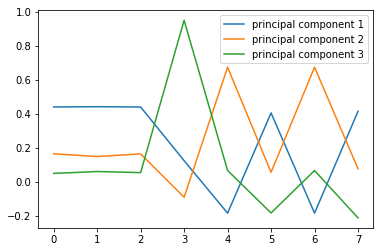

0.914974406103 [ 0.56483227  0.22994478  0.12019736]


In [35]:
from sklearn.decomposition import PCA

num = 3
pca = PCA(n_components=num)
principalComponents = pca.fit_transform(pcadf)
principalDf = pandas.DataFrame(data = pca.components_.T
             , columns = ['principal component '+str(x) for x in range(1,num+1)])
principalDf.plot()
pyplot.show()
print sum(pca.explained_variance_ratio_),pca.explained_variance_ratio_


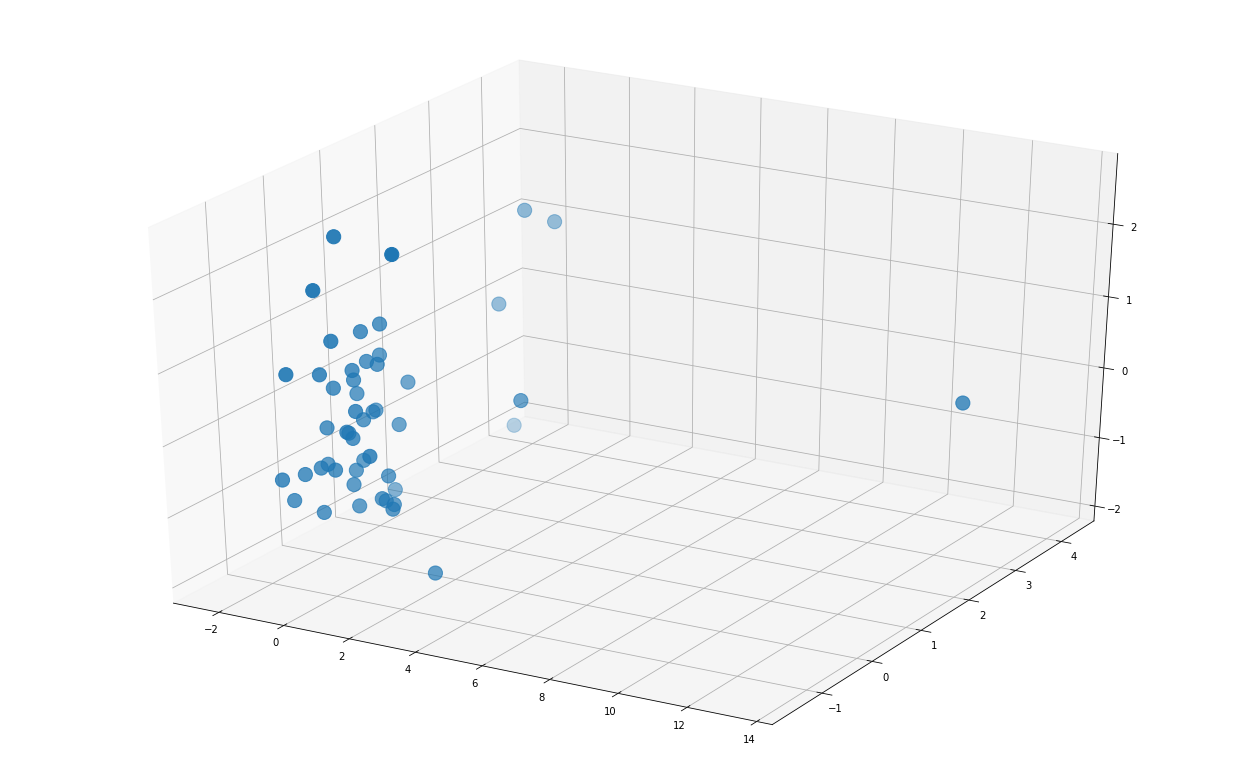

In [38]:
from mpl_toolkits.mplot3d import axes3d
# Create plot
fig = pyplot.figure(figsize=(22,14))
ax = fig.add_subplot(1, 1, 1,projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2],s=200)

['FL', 'IL', 'MA', 'NJ', 'NY', 'PA', 'TX']
['AL', 'AR', 'IA', 'ID', 'IN', 'KS', 'KY', 'MS', 'MT', 'NE', 'OK', 'SC', 'SD', 'WV']
['CA']
['AK', 'LA', 'ND', 'WY']
['AZ', 'CO', 'HI', 'NM', 'NV', 'UT']
['CT', 'DE', 'GA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NH', 'OH', 'OR', 'RI', 'TN', 'VA', 'VT', 'WA', 'WI']


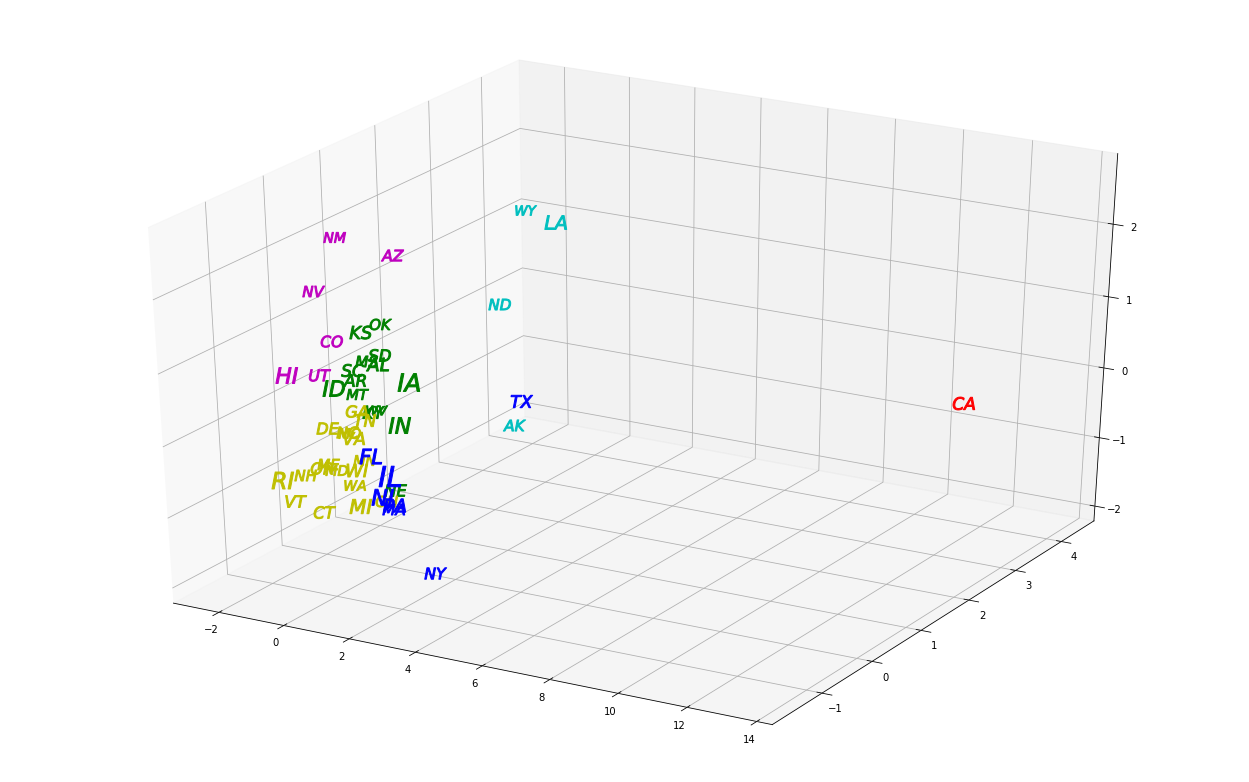

In [40]:
from sklearn.cluster import KMeans
clustnum=6
kmeans = KMeans(n_clusters=clustnum,n_init=50,max_iter=1000)  
kmeans.fit(principalComponents)

fig = pyplot.figure(figsize=(22,14))
ax = fig.add_subplot(1, 1, 1,projection='3d')
cs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
newslopes = slopes.copy()
allmean = numpy.mean(slopes.values())
for k in range(clustnum):
    stategroup = [kdf.index[x] for x in range(50) if kmeans.labels_[x]==k]
    meanslope = numpy.mean([newslopes[state] for state in newslopes.keys() if state in stategroup])
    for state in stategroup:
        if state not in slopes.keys():
            if numpy.isnan(meanslope):
                newslopes[state] = allmean
            else:
                newslopes[state] = (meanslope + allmean)/2
            
    print stategroup
for i,state in enumerate(kdf.index):
    label = cs[kmeans.labels_[i]]
    mark = '$'+kdf.index[i]+'$'
    ax.scatter(principalComponents[i,0],principalComponents[i,1],principalComponents[i,2],s=500,marker = mark,c=[label])

In [44]:
insoldict = kdf.new_insolation.to_dict()
gdpdict = kdf.GDP.to_dict()
# insoldict.items()

roidict = {}
for key in insoldict.keys():
    roidict[key] = newslopes[key]*insoldict[key]
roidict = dict(sorted(roidict.items(), key=lambda kv: -kv[1]))
roidict

{'AK': 3.5354478668667255,
 'AL': 3.6615168461163261,
 'AR': 1.7231313257838505,
 'AZ': 7.3068809748294283,
 'CA': 3.4737413364886733,
 'CO': 8.2679362665243747,
 'CT': 2.9159915020432599,
 'DE': 4.1968762169792777,
 'FL': 2.4553192894475786,
 'GA': 6.2774696503630709,
 'HI': 7.8927768547800055,
 'IA': 3.3325524419730637,
 'ID': 3.5900028452156167,
 'IL': 4.0175847671573859,
 'IN': 3.2610384410723214,
 'KS': 3.8832102489085258,
 'KY': 3.3611580423333476,
 'LA': 5.6023250813426788,
 'MA': 2.3695964101040028,
 'MD': 16.018774816526161,
 'ME': 5.2432505125638,
 'MI': 5.1710956889964024,
 'MN': 2.2551262331658308,
 'MO': 5.7951849490042644,
 'MS': 3.6472140459361819,
 'MT': 3.4112178429638433,
 'NC': 6.1211341993003927,
 'ND': 4.9387487124845943,
 'NE': 2.624563833056039,
 'NH': 7.8297115147667027,
 'NJ': 1.5334922945226981,
 'NM': 9.2213164547513902,
 'NV': 18.149251562291465,
 'NY': 4.0616838959272252,
 'OH': 5.1959245696244123,
 'OK': 3.876058848818456,
 'OR': 4.746278757387266,
 'PA': 

In [47]:
BokehMap(roidict,1,20,'Power per Dollar','')